In [1]:
import pandas as pd

# Load the CSV file containing labels
df = pd.read_csv('label.csv')
allClasses=df['label'].unique()
imagesPerClass = df['label'].value_counts()

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from skimage.feature import hog, local_binary_pattern
from skimage.color import rgb2gray
from skimage.filters import gabor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, classification_report
import cv2
from skimage import filters
# https://github.com/henrhoi/image-classification/blob/master/feature_extraction_and_exploratory_data_analysis.ipynb
# https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/
# https://medium.com/@girishajmera/hog-histogram-of-oriented-gradients-an-amazing-feature-extraction-engine-for-medical-images-5a2203b47ccd
# https://www.geeksforgeeks.org/hog-feature-visualization-in-python-using-skimage/
# Load Dataset

def preprocess_image(image, target_size=(170,170)):
    image_resized = np.array(Image.fromarray(image).resize(target_size))
    return image_resized

def extract_hog_features(image):
    image_gray = rgb2gray(image)
    features, _ = hog(image_gray, block_norm='L2-Hys', pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
    return features

def extract_color_histogram(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hist = cv2.calcHist([image_rgb], [0, 1, 2], None, [16, 16, 16], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_sift_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is not None:
        return descriptors.flatten()[:128] 
    return np.zeros(128) 

def extract_lbp_features(image):
    image_gray = rgb2gray(image)
    lbp = local_binary_pattern(image_gray, P=8, R=1, method='uniform')  
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=True)
    return hist

hogFeatures=[]
histoFeatures=[]
lbpFeatures=[]
siftFeatures=[]
image_labels=[]
def extract_combined_features(image):
    processed_image = preprocess_image(image)
    chog_features = extract_hog_features(processed_image)
    ccolor_histogram = extract_color_histogram(processed_image)
    clbp_features = extract_lbp_features(processed_image)
    hogFeatures.append(chog_features)
    histoFeatures.append(ccolor_histogram)
    lbpFeatures.append(clbp_features)
    siftFeatures(extract_sift_features(processed_image))
for idx, row in df.iterrows():
    image_name = row['filename']
    label = row['label']
    image_path = os.path.join('data', image_name)
    image = np.array(Image.open(image_path))
    extract_combined_features(image)
    image_labels.append(label)



C:\Users\siddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [3]:
hogFeatures_np = np.array(hogFeatures)
histoFeatures_np = np.array(histoFeatures)
lbpFeatures_np = np.array(lbpFeatures)
siftFeatures_np=np.array(siftFeatures)


In [4]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
# import cv2
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
combined_features2 = np.concatenate([hogFeatures_np, histoFeatures_np,lbpFeatures_np], axis=1)
X_train, X_test, y_train, y_test = train_test_split(combined_features2, image_labels, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
rf_model = RandomForestClassifier(random_state=42, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=300)
xgb_model = xgb.XGBClassifier(random_state=42, n_estimators=300, learning_rate=0.1, max_depth=6)
ensemble_model = VotingClassifier(estimators=[('rf', rf_model), ('xgb', xgb_model)], voting='soft')
ensemble_model.fit(X_train, y_train)
y_pred_ensemble = ensemble_model.predict(X_test)
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Model Accuracy: {accuracy_ensemble}")
print("Ensemble Classification Report:")
print(classification_report(y_test, y_pred_ensemble))


Ensemble Model Accuracy: 0.4126984126984127
Ensemble Classification Report:
                    precision    recall  f1-score   support

           calling       0.25      0.20      0.22       173
          clapping       0.42      0.41      0.42       160
           cycling       0.60      0.63      0.62       186
           dancing       0.50      0.51      0.50       180
          drinking       0.26      0.24      0.25       152
            eating       0.50      0.77      0.60       151
          fighting       0.53      0.57      0.55       186
           hugging       0.33      0.28      0.31       151
          laughing       0.48      0.45      0.46       179
listening_to_music       0.21      0.19      0.20       176
           running       0.43      0.46      0.44       155
           sitting       0.37      0.27      0.31       163
          sleeping       0.44      0.52      0.47       162
           texting       0.30      0.25      0.27       183
      using_laptop     

In [10]:
import pickle
import xgboost as xgb

with open('42_voting.pkl', 'wb') as file:
    pickle.dump(ensemble_model, file)

In [11]:
with open('42_voting.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
    y_pred = loaded_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.4126984126984127


C:\Users\siddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


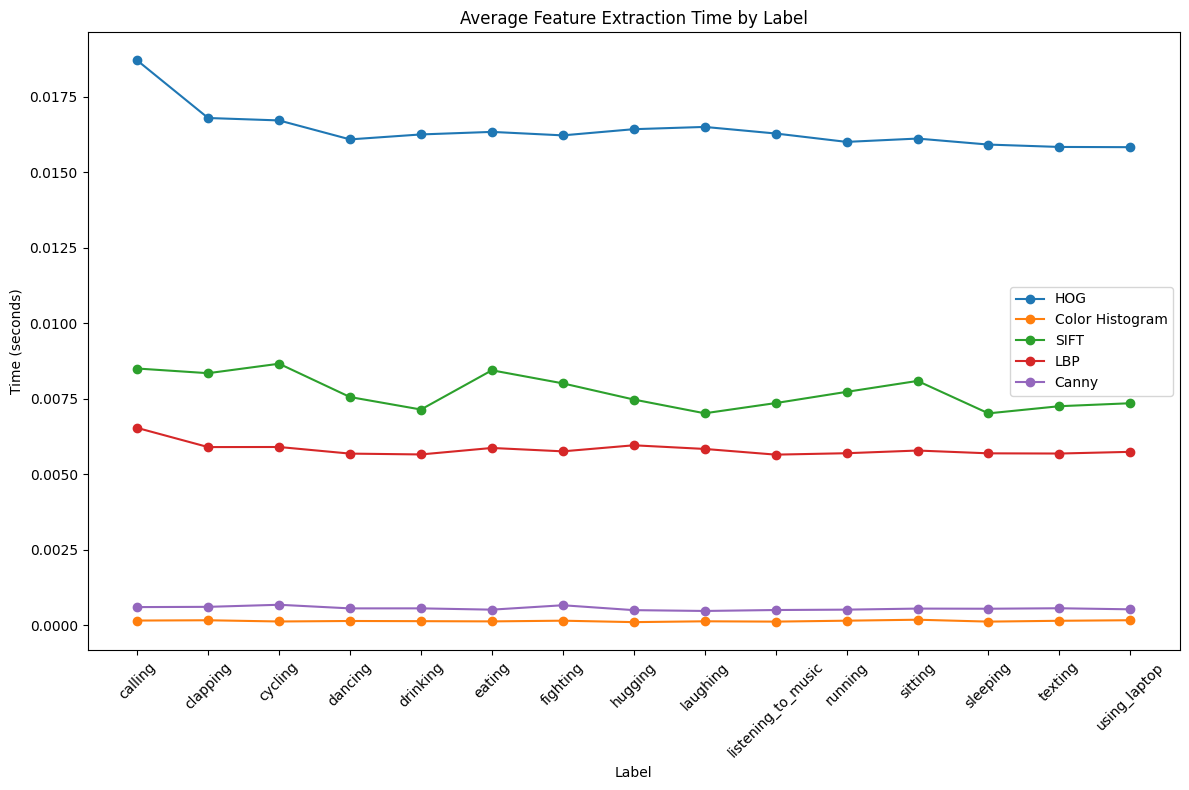

In [2]:
# import os
# import numpy as np
# import pandas as pd
# from PIL import Image
# from skimage.feature import hog, local_binary_pattern
# from skimage.color import rgb2gray
# import cv2
# import time
# import matplotlib.pyplot as plt
# import seaborn as sns

# def preprocess_image(image, target_size=(170,170)):
#     image_resized = np.array(Image.fromarray(image).resize(target_size))
#     return image_resized

# def extract_hog_features(image):
#     image_gray = rgb2gray(image)
#     features, _ = hog(image_gray, block_norm='L2-Hys', pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
#     return features

# def extract_color_histogram(image):
#     image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     hist = cv2.calcHist([image_rgb], [0, 1, 2], None, [16, 16, 16], [0, 256, 0, 256, 0, 256])
#     hist = cv2.normalize(hist, hist).flatten()
#     return hist

# def extract_sift_features(image):
#     sift = cv2.SIFT_create()
#     keypoints, descriptors = sift.detectAndCompute(image, None)
#     if descriptors is not None:
#         return descriptors.flatten()[:128]  
#     return np.zeros(128) 

# def extract_lbp_features(image):
#     image_gray = rgb2gray(image)
#     lbp = local_binary_pattern(image_gray, P=8, R=1, method='uniform') 
#     n_bins = int(lbp.max() + 1)
#     hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=True)
#     return hist

# def extract_canny_edges(image):
#     edges = cv2.Canny(image, threshold1=100, threshold2=200)
#     return edges.flatten()
# def process_images(df, sample_size=50):
#     timings = []
#     grouped_df = df.groupby('label').sample(n=sample_size, random_state=42)
#     for idx, row in grouped_df.iterrows():
#         image_name = row['filename']
#         label = row['label']
#         image_path = os.path.join('data', image_name)
#         image = np.array(Image.open(image_path))
#         processed_image = preprocess_image(image)
#         start_time = time.time()
#         extract_hog_features(processed_image)
#         hog_time = time.time() - start_time
#         start_time = time.time()
#         extract_color_histogram(processed_image)
#         color_hist_time = time.time() - start_time
#         start_time = time.time()
#         extract_sift_features(processed_image)
#         sift_time = time.time() - start_time
#         start_time = time.time()
#         extract_lbp_features(processed_image)
#         lbp_time = time.time() - start_time
#         start_time = time.time()
#         extract_canny_edges(processed_image)
#         canny_time = time.time() - start_time
#         timings.append({
#             'label': label,
#             'HOG': hog_time,
#             'Color Histogram': color_hist_time,
#             'SIFT': sift_time,
#             'LBP': lbp_time,
#             'Canny': canny_time
#         })
#     return pd.DataFrame(timings)
# def plot_average_extraction_times(df):
#     avg_times = df.groupby('label').mean().reset_index()
#     features = ['HOG', 'Color Histogram', 'SIFT', 'LBP', 'Canny']
#     for feature in features:
#         plt.plot(avg_times['label'], avg_times[feature], marker='o', label=feature)
#     plt.title('Average Feature Extraction Time by Label')
#     plt.xlabel('Label')
#     plt.ylabel('Time (seconds)')
#     plt.legend()
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

# timing_results = process_images(df, sample_size=200)
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Call the function for a specific label

# # Plot the feature extraction times
# plot_average_extraction_times(timing_results)
